# Lecture 17: Parameter Estimation

CBIO (CSCI) 4835/6835: Introduction to Computational Biology

## Overview and Objectives

Computational models are a great way of representing some phenomenon of interest. However, there's usually a "training" step before a model becomes useful, where you have to "fit" the model's parameters to real-world data. You can view this as a kind of "calibration" step, so the future predictions are rooted in reality. Unfortunately, for most real-world models, this calibration step can actually be quite difficult. In this lecture, we'll discuss some principled ways of inferring model parameter values. By the end of this lecture, you should be able to

 - Define parameter estimation
 - Create a cost function to evaluate your model in a rigorous estimation framework
 - Provide some gradient-based and gradient-free methods for evaluating your cost function
 - Implement grid-search cross-validation to brute-force your model parameters

## Part 0: A Friendly Face

First, some preliminaries.

In [1]:
%matplotlib inline
# so the figures will appear "inline"
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sig
import seaborn as sns
sns.set()

In [2]:
def step(t, X):
    ax = a * X[0]
    bxy = b * X[0] * X[1]
    cxy = c * X[0] * X[1]
    dy = d * X[1]
    
    return np.array([int(ax - bxy), int(cxy - dy)])

Anyone recognize this differential equation?

**Predator-Prey equations!** (aka, the _Lotka-Volterra model_ for competition)

What do you think about this line?

`return np.array([int(ax - bxy), int(cxy - dy)])`

A slight tweak from Lecture 15--the addition of the `int()` castings on both populations! **What effect will this have?**

Populations can now go to 0! And if one does go to zero, it never recovers.

In [3]:
def plot_pp(x, y, labels):
    """
    This function just plots the data, given the x and y axes, and the labels for each.
    """
    plt.plot(x, y[0], label = labels[0])
    plt.plot(x, y[1], label = labels[1])
    plt.ylim([0, y.max() + 2])  # Fix the bottom of the y-axis at 0 so we can always see it.
    plt.legend(loc = 0)

In [4]:
# These are all taken straight out of Lecture 15.
a = 1.0    # Prey growth
b = 0.1    # Predation rate
c = 0.075  # Predator growth
d = 1.0    # Predator death

In [5]:
t = [0, 15]
dt = np.linspace(t[0], t[1], 10000)
X0 = np.array([10, 5])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
print(X["message"])
print("Success?", X["success"])

The solver successfully reached the end of the integration interval.
Success? True


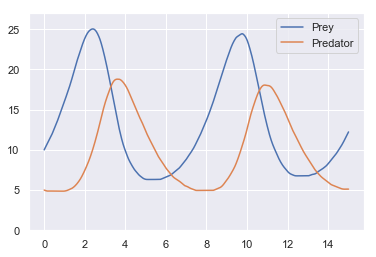

In [6]:
labels = ["Prey", "Predator"]
plot_pp(X["t"], X["y"], labels)

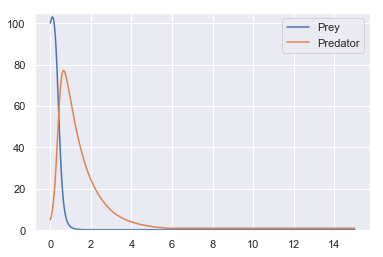

In [7]:
X0 = np.array([100, 5])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

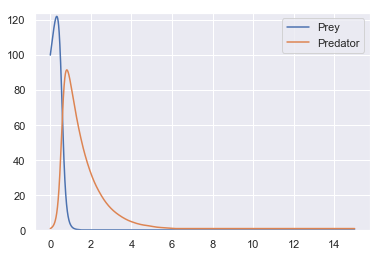

In [8]:
X0 = np.array([100, 1])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

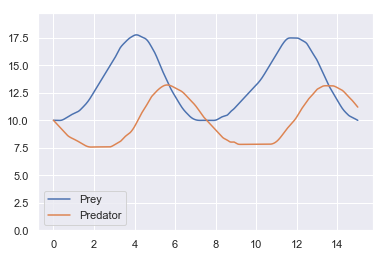

In [9]:
X0 = np.array([10, 10])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

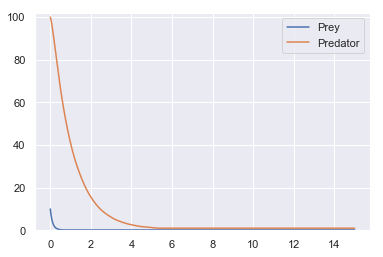

In [10]:
X0 = np.array([10, 100])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

This seems like a lot of work to figure out what combinations of initial population values result in one or both species going extinct...

The main question of this lecture: _Is there a better way?_

The main point of this lecture: _Yes, and here's how!_

## Part 1: What is "parameter estimation"?

Recall what a _model_ is:

 - A "summary" of our understanding of a system (e.g., a biological mechanism)

 - Enables predictions that test our own understanding

 - Describes aspects of a system that may not be directly accessible via observation

To function, almost every model ever has some associated "numbers", so-called _parameters_.

(remember Gaussian/Normal/bell-curve distributions? they have two parameters: a _mean_, and a _variance_)

Even if a model is "almost correct", their parameters usually need some "reasonable" numerical values to function properly.

How do we choose these parameters?

If I had the following scatter plot of data and wanted to "fit" a 2D Gaussian model to it, what would I choose for the mean and (co)variance?

![gaussianscatterplot](ParameterEstimation/gaussianscatterplot.png)

A mean of (0, 0) and a covariance around +/- 100 would be a decent guess.

If you have a case like the last one where it's one small set of data that you can visualize (e.g., in 2D or 3D), just a handful of parameters you need to set (e.g., a mean and a covariance), and you can easily verify "correctness", then absolutely go for it!

Alternatively, the literature can often have experimentally-determined values (i.e., other researchers that have already done what I just described) that you can plug in and verify yourself.

**Unfortunately...*

 - Data are frequently much higher-dimensional than just 2D or 3D (i.e., they're really hard to visualize as a way of "checking" your parameter values--how about a 10D Gaussian?)

 - Data are getting _bigger_. If it took you a few hours to calculate a single model from your data, you'd have a hard time doing "guess-and-check" with each one in a reasonable amount of time.

 - Visual "guess-and-check" for validation of model parameters isn't always a feasiable strategy. Even with our toy Lotka-Volterra model, it would be really hard to figure out a decent definition of "best" parameter values in a reasonable amount of time.

**We need a more automated, computational approach to inferring parameters from experimental data.**

### The setup: experimental data

First, you have your experimental data that you want to model.

![expdata](ParameterEstimation/experimentaldata.png)

### The setup: model

Next, you have your model that you want to "fit".

![expdata](ParameterEstimation/model.png)

### The setup: cost function

Third, and most importantly, you have a _cost function_.

![expdata](ParameterEstimation/costfunction.png)

What is a "cost function"?

Formally, it's an equation that quantifies the discrepancy between your experimental data and your model's predictions.

Informally, it's a precise way of "nudging" your model's parameters in a direction that makes the predictions of your model more closely resemble reality.

As such, creating an effective cost function is _critical_--a bad cost function will result in a bad model.

**There are several ways of developing and solving cost functions to set your model parameters.** We'll discuss a few here.

## Part 2: Gradient-based methods

Remember how we said a cost function is critical to evaluating your model? That's because a well-defined cost function--indeed, like any other function--can have a _derivative_ (or _gradient_, in high dimensions).

![expdata](ParameterEstimation/gradient.png)

The "cost" function is so-named to provide us with some intuition about how we need to use it to find the "best" parameters for our model.

 - When the cost function has a high value, this means there is a _high cost_ to using the corresponding model parameters. Intuitively, this usually means the model parameters don't reflect reality very well.

 - Conversely, when the cost function has a low value, this means there is a _low cost_ to using the corresponding model parameters. Usually, this means the model parameters have a good alignment with the real-world.

So if the goal is to make the cost function have a low value--does anyone remember how to find the minimum of a function $f(x)$?

**Take the derivative, set it equal to zero, and solve!**

### That's it, you're done!

...unfortunately, not quite. Let's illustrate by creating a cost function for our Lotka-Volterra model.

A cost function is an excellent opportunity to encode your domain knowledge into the problem. **What, in your mind, would constitute a "good" Lotka-Volterra model of stabile predator-prey populations?**

Here's my list:
 - Neither population goes to 0 (no one goes extinct)
 - Of the non-extinct populations, I like the ones where the two find as stable an equilibrium as possible (the absolute values of the populations change as little as possible)

How could we design a "cost" function to encourage this behavior? (in terms of "high" and "low" costs)

 - Impose a "high" cost whenever one or both populations go to 0
 - Impose a cost that is inversely proportional to how much the two populations vary

### My cost function

In [11]:
def my_cost_func(Y):
    """
    My little cost function, where Y is a tuple
    with the initial prey and predator populations.
    """
    a = 1.0
    b = 0.1
    c = 0.075
    d = 1.0
    t = [0, 15]
    dt = np.linspace(t[0], t[1], 10000)
    X = sig.solve_ivp(step, t, Y, t_eval = dt)
    y_prey, y_pred = X["y"]

    # First: if either population went to 0,
    # we want to give it the maximum possible cost.
    if y_prey[-1] == 0 or y_pred[-1] == 0:
        # This is a little cheat that returns the 
        # maximum possible float value NumPy can store
        # (note: it's a really, really big number)
        return np.finfo(np.float).max
    
    # If both populations were non-zero, let's create
    # an inversely-proportional cost: it goes up as
    # the populations see-saw more, and goes down as
    # the populations level out.
    prey_ratio = y_prey.max() / y_prey.min()
    pred_ratio = y_pred.max() / y_pred.min()
    cost = ((prey_ratio + pred_ratio) / 2) - 1 # why a -1?
    return cost

**Pause -- did that cost function make sense?**

Let's see if works! Remember, things we don't want (extinction, large population oscillations) should have _high_ costs; things we **do** want (stable populations) should have _low_ costs.

Here's the initial model from both this lecture, and the lecture on computational models:

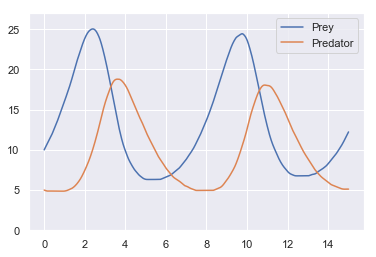

In [12]:
X0 = np.array([10, 5])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

Its value from the cost function:

In [13]:
my_cost_func(X0)

2.91390230316226

Not terribly contextual or intuitive, but hopefully it makes more sense with more examples.

Here's the one with more "stable" populations (spoiler alert: this should have a lower cost!).

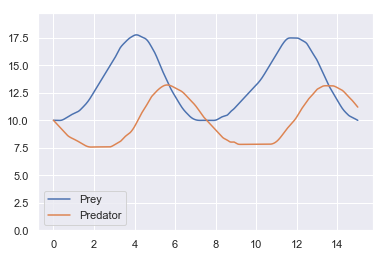

In [14]:
X0 = np.array([10, 10])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

And its cost function:

In [15]:
my_cost_func(X0)

0.7628457411212077

**YAY!** Half the value of the previous model! We don't really care here about what _absolute_ differences mean, just that this does indeed give us a _lower_ cost for _more preferred_ behavior.

Now, the last case: what about extinction events?

Here's one.

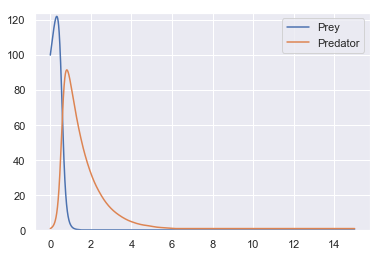

In [16]:
X0 = np.array([100, 1])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

And its cost function:

In [17]:
my_cost_func(X0)

311.3259407666182

_SUPER_ high! Exactly what we wanted!

**Our cost function seems to work!** It gives high costs to models we don't want, and low costs to models we do want.

Back to gradient-based methods! So we should just be able to take the derivative of our cost function, set it to 0, and solve for our starting population values, right? Right?

Well, if you could tell me how to take the derivative of a function that boils down to ratios, I'm all ears.

**This is where gradients come in.**

![expdata](ParameterEstimation/gradient.png)

We can't compute "closed-form" derivatives, but we _can_ take instantaneous derivatives to tell us which direction we should go, take a small step in that direction, and then take another instantaneous derivative, repeating this process until our derivative becomes 0 (or close to it).

The simplest approach is the _steepest descent_, a simple version of [Newton's Method](https://en.wikipedia.org/wiki/Newton's_method).

$$\theta_{k + 1} = \theta_k - \lambda \nabla F(\theta_k)$$

where $\theta_k$ are our _current_ parameter values, $F(theta_k)$ is our cost function evaluated at our current parameter values, $\nabla$ indicates the instantaneous gradient of our cost function, and $\lambda$ is our small step size.

We can use the `scipy.optimize` submodule to do this automatically for us. This function takes 1) our cost function (yes, the _function_) and 2) our initial parameter values as input.

In [18]:
import scipy.optimize as opt

In [19]:
out = opt.minimize(my_cost_func, [10, 5], method = "COBYLA")

In [20]:
print(out["x"])

[12.50110147 10.75749678]


Ooh, let's try these values out and see what they look like!

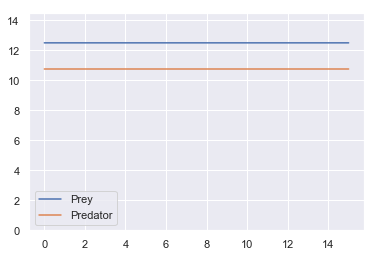

In [21]:
X0 = np.array([12.50110147, 10.75749678])
X = sig.solve_ivp(step, t, X0, t_eval = dt)
plot_pp(X["t"], X["y"], labels)

**It's perfect!**

(Real talk: when I ran this, I was absolutely NOT expecting a literal perfect solution. I figured there would be something _close_ but still wavy. Goes to show what an analytical approach to estimation will get you!)

Just for the sake of completeness, what do you think the value of the cost function was?

In [22]:
my_cost_func(out["x"])

0.0

Literally can't get any better than 0.

## Part 3: Gradient-free methods

So, I have to admit to some fudging in the previous section. I included the `scipy.optimize.minimize` bit in the gradient-based method, but some of you may have noticed something weird about the function call:

`out = opt.minimize(my_cost_func, [10, 5], method = "COBYLA")`

What's that weird `method = "COBYLA"` bit? That doesn't resemble the Newton method we were discussing around that time.

**Because it's not.** In fact, it's not even a gradient-based method, _because we couldn't compute direct gradients off our function_.

The method we used is named "Constrained Optimization BY Linear Approximation", and relies on local linear approximations to suss out the gradient.

Think: $f(x) - f(x + h)$ for some small value of $h$. That's a gradient _approximation_ that is locally linear, but it's not an actual derivative, which we needed for Newton's method.

**Fun fact**: If you tried Newton's method for that SciPy function call--re-run ths lecture and put in `"Newton-CG"` in that `method = ` part--it'll crash and complain about the lack of something called a "Jacobian", which is high-dimensional lingo for "first derivative". Yep--can't run Newton's Method with the first derivative!

More generally, there are specific instances where gradient-based methods fail. Can you name any?

![expdata](ParameterEstimation/gradientfail.png)

In these cases, it's impossible to compute a gradient. We could do a simple linear approximation like COBYLA did, but that can still be dicey.

Instead, we'll look at two of my personal favorite methods, both _stochastic_ approaches to finding good parameter values.

### Genetic Algorithms

In another biology-inspired class of algorithms (see also: neural networks, and the subtopic after this one), genetic algorithms seek to minimize a cost function through _evolution_ of parameter populations. 

Genetic algorithms (GAs) will typically maintain a small population of parameter values, and solve the cost function for each member of the population.

Then, GAs will often take the best performers--say, the top 10% of the population with the lowest cost function--as "parents" for the next generation.

Often there is then some "cross-over" and point mutations applied to this new parent generation, before the generation then reproduces, producing another population of parameter values that are then evaluated with the cost function.

![genetic_algorithms](ParameterEstimation/genetic_algorithms.png)

The terminology is [roughly] adopted from biology:
 - _genes_ are individual parameter values (e.g., one gene would be the prey population)
 - _chromosomes_ are single individuals in the population (e.g., one combination of both prey and predator populations)
 - the _population_ is the total number of parameter combinations (e.g., choose 50 initial combinations of prey/predator values)

_Cross-over_ entails the exchange of "genes" between "chromosomes", where individual parameter values are swapped between members of the population.

Finally, _mutation_ is where a single gene is arbitrarily changed to something else.

Here is the general sequence of events in GAs:

![genetic_algorithms](ParameterEstimation/ga_flowchart.png)

One way to think of GAs--and really, parameter estimation in general--is that of a _search_ algorithm (like Google!).

The goal of a GA is to _find_ an optimal combination of parameter values _without_ having to search all possible combinations. But why the populations? Why not just evolve a single set of parameter values?

Remember the "multimodal" cost functions that gave gradient-based cost minimization problems? That's still a problem here. GAs try to get around this by having a population--in general, it's evolved toward better solutions, but each individual still acts somewhat randomly through _cross-over_ and _mutation_, so it can potentially escape those "local" dips.

**The problem of "local minima" is an unsolved problem!** This tension between _exploration_ (broad, scattershot searching) and _exploitation_ (refining an existing "good" set of parameters) comes up here!

### Particle Swarm Optimization

Closely related to GAs, also inspired by biology, and an approach that tries _even more explicitly_ to address the exploration-exploitation trade-off, is that of Particle Swarm Optimization (PSO).

The inspiration comes from watching large swarms of birds or schools of fish moving somewhat in unison, but with a few members taking some unexpected deviations.

Like GAs, PSO tries to simultaneously _explore_ as wide an area as possible with a population of moving "particles" that can cover a decent number of possible parameter combinations, while _exploiting_ the best solution it's discovered so far in an effort to try and make it even better.

![pso](ParameterEstimation/pso.png)

https://www.youtube.com/watch?v=GUkjC-69vaw

PSO is nice because it's relatively straightforward to implement and use.

 - You have $S$ particles (usually something small, like 50 or 100)

 - Each particle keeps track of **three things**: its **position** $x$, its **velocity** $v$, and the **best solution** $p$ (position, in terms of the cost function) it has found so far

 - Globally, there are **four other things** to keep track of (only **two** of which change)
   1. the **best global solution** _any_ particle has found so far, $g$ (in terms of the cost function)
   2. $c_1$ and $c_2$, called the "cognitive" and "social" parameters--these modulate _exploration_ and _exploitation_, respectively
   3. the inertia factor $\omega$, which starts at 1 and is gradually reduced

Then, for each particle:

 - Generate two uniform random numbers, $r_1$ and $r_2$, between 0 and 1 (this helps inject some unpredictability into PSO)

 - Compute the particle's new velocity $v$:
$$ v(t + 1) = \omega v(t) + c_1 r_1 (p(t) - x(t)) + c_2 r_2 (g(t) - x(t)) $$

 - And its new position $x$:
$$ x(t + 1) = x(t) + v(t + 1) $$

 - Update the particle's best position $p$ if its current position $x(t + 1)$ is better (otherwise leave it alone)

Once all the particles have been updated, find the _best_ $p$ among them and make that the best _global_ position $g$

PSO takes the idea of search that we discussed from GAs and makes it a very explicit goal.

The two coefficients, $c_1$ and $c_2$, explicitly encode how important it is to either explore as wide an area as possible or refine the best values found so far.

...but the random numbers $r_1$ and $r_2$ allow for some flexibility, occasionally boosting one strategy or the other at random.

The inertia term steadily decreases over time, so the particles slow as the search goes on, hopefully converging to better and better values.

## Part 4: Cross-validation

...which is really just a fancy euphemism for "structured guess-and-check", or even "brute-force search".

![cv](ParameterEstimation/cv.png)

Cross-validation is a statistical technique for estimating the best model on a limited amount of data. It plays a HUGE role in training machine learning models, but can also be used to select computational models.

It is, effectively, a simulation: by "holding out" a small portion of data, it trains the model on the remaining data, then uses the held-out subset to "simulate" what the model would do in the presence of new data.

It's also a great way of performing a grid search for optimal parameter values. The `scikit-learn` Python library has a great utility for helping us with this: `ParameterGrid`.

In [23]:
from sklearn.model_selection import ParameterGrid

It's really nothing more than an easy way to create "combinations" of parameter values to test. To do this, just define ranges of the parameters you want to run through your cost function.

In [24]:
prey_range = np.linspace(1, 30, 30, dtype = np.int)
pred_range = np.linspace(1, 30, 30, dtype = np.int)

# A regular dictionary.
param_grid = {"y_prey": prey_range, "y_pred": pred_range}

# That goes to the ParameterGrid object.
cv = ParameterGrid(param_grid)

`ParameterGrid` will basically generate all the combinations for us; all we have to do now is write a loop!

In [25]:
hist = np.zeros(shape = (30, 30))

num = 0
for combination in cv:
    # keys corresponds to the keys in param_grid dictionary!
    y_pred = combination["y_pred"]
    y_prey = combination["y_prey"]
    cost = my_cost_func([y_prey, y_pred])
    hist[y_prey - 1, y_pred - 1] = cost
    num += 1
print("Ran {} combinations.".format(num))

Ran 900 combinations.


Now we can use that mysterious `hist` matrix to visualize the results!

Text(0.5, 0, 'Predator')

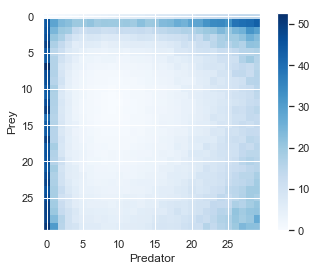

In [26]:
plt.imshow(hist, cmap = "Blues")
plt.colorbar()
plt.ylabel("Prey")
plt.xlabel("Predator")

Some key take-aways:

 - For very small values of _either_ population, they seem to crash regardless of what the other population is. But beyond that, there's a large "stable" region, particularly around small-but-not-too-small initial populations.

 - Grid searches can help you to understand the "structure" of the cost function--there is clearly a pattern in how the predator-prey equations change, depending on their initial parameter values. 

 - Grid searchers can be computationally expensive! We only explored 30 possible starting populations for prey, and 30 for predators. This resulted in _900_ combinations of those two parameters! If we included the rate constants as well, this would very quickly explode in computational complexity.

## Administrivia

 - How is Assignment 4 going? Due Thursday!

 - Final project proposals are due **Thursday!** Let me know if there are questions.

## References

 - "A Framework for Parameter Estimation and Model Selection from Experimental Data in Systems Biology Using Approximate Bayesian Computation". _Nat Protoc_. 2014; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5081097/pdf/emss-70224.pdf
 - Intuition for Newton's Method https://math.stackexchange.com/questions/609680/newtons-method-intuition
 - Stanford notes on gradient descent methods http://adl.stanford.edu/aa222/lecture_notes_files/chapter6_gradfree.pdf
 - Gradient free methods http://www.tik.ee.ethz.ch/education/lectures/DSE/population_based.pdf
 - PSO video https://www.youtube.com/watch?v=tTNmx0xw2QY